<a href="https://colab.research.google.com/github/jitbnerejee4/jit/blob/fastai/m5_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
%reload_ext autoreload
%autoreload 2
from fastai.tabular import *
from fastai.basics import *

In [0]:
path = Path('/content')

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c m5-forecasting-accuracy

 49% 7.00M/14.2M [00:00<00:00, 70.6MB/s]
100% 14.2M/14.2M [00:00<00:00, 69.9MB/s]
 51% 8.00M/15.5M [00:00<00:00, 46.6MB/s]
100% 15.5M/15.5M [00:00<00:00, 61.7MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 164MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 103MB/s]


In [5]:
!unzip 'sell_prices.csv.zip'
!unzip 'sample_submission.csv.zip'
!unzip 'sales_train_validation.csv.zip'

Archive:  sell_prices.csv.zip
  inflating: sell_prices.csv         
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  sales_train_validation.csv.zip
  inflating: sales_train_validation.csv  


In [6]:
path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/sales_train_validation.csv.zip'),
 PosixPath('/content/sales_train_validation.csv'),
 PosixPath('/content/sample_submission.csv.zip'),
 PosixPath('/content/sell_prices.csv'),
 PosixPath('/content/sell_prices.csv.zip'),
 PosixPath('/content/sample_submission.csv'),
 PosixPath('/content/calendar.csv'),
 PosixPath('/content/sample_data')]

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [0]:
pd.options.display.max_columns = 50

In [10]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv(path/"sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv(path/"calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(path/"sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [0]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [0]:
FIRST_DAY = 350 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [14]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

CPU times: user 31.6 s, sys: 2.74 s, total: 34.4 s
Wall time: 34.4 s


In [15]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.97
1,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,4.34
2,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,2.48
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,0.50
4,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,1.77


In [16]:
df.shape

(40718219, 22)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40718219 entries, 0 to 40718218
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
dtypes: datetime64[ns](1), float32(5), int16(14), object(2)
memory us

In [18]:
create_fea(df)
df.shape

(40718219, 31)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40718219 entries, 0 to 40718218
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [0]:
df = df.assign(d = df.d.str[2:].astype(int))

In [21]:
df.dropna(inplace = True)
df.shape

(39041269, 31)

In [0]:
useless_cols = ["date", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
dep_var= 'sales'
cat_vars = ['item_id','dept_id', 'store_id', 'cat_id', 'state_id', 'event_name_1', 'event_name_2',
             'event_type_1', 'event_type_2']
cont_vars = ['wday', 'month', 'year','snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7', 'lag_28', 'rmean_7_7',
             'rmean_28_7', 'rmean_7_28', 'rmean_28_28', 'week', 'quarter', 'mday']

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
train_ds = df[df.d < 1886]

In [25]:
train_ds.drop(useless_cols, axis=1)

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
869062,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,405,0.0,6,3,2012,24,3,0,0,1.0,0.0,1.0,3.97,0.0,0.0,0.000000,0.142857,0.214286,0.214286,10,1,8
869063,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,406,0.0,7,3,2012,0,0,0,0,1.0,1.0,1.0,3.97,0.0,1.0,0.000000,0.142857,0.178571,0.250000,10,1,9
869069,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,405,1.0,6,3,2012,24,3,0,0,1.0,0.0,1.0,4.34,3.0,2.0,1.857143,1.142857,1.392857,1.678571,10,1,8
869070,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,406,2.0,7,3,2012,0,0,0,0,1.0,1.0,1.0,4.34,1.0,0.0,2.000000,1.000000,1.392857,1.607143,10,1,9
869076,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,405,0.0,6,3,2012,24,3,0,0,1.0,0.0,1.0,2.98,0.0,0.0,0.000000,1.857143,0.750000,0.642857,10,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40016929,FOODS_3_825_WI_3_validation,3046,6,9,2,2,1885,1.0,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.98,0.0,0.0,1.000000,0.428571,1.178571,0.642857,12,1,27
40016935,FOODS_3_826_WI_3_validation,3047,6,9,2,2,1884,2.0,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,0.0,1.428571,0.000000,0.821429,1.000000,12,1,26
40016936,FOODS_3_826_WI_3_validation,3047,6,9,2,2,1885,4.0,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.28,1.0,0.0,1.142857,0.000000,0.857143,0.892857,12,1,27
40016942,FOODS_3_827_WI_3_validation,3048,6,9,2,2,1884,0.0,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.00,1.0,4.0,2.142857,1.571429,1.607143,1.607143,12,1,26


In [26]:
test_ds = df[df.d >= 1886]
test_ds = test_ds.assign(id=test_ds.id + "_" + np.where(test_ds.d <= 1913, "validation", "evaluation"),
                   F="F" + (test_ds.d - 1885 - 28 * (test_ds.d > 1913)).astype("str"))
test_ds.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,F
39803521,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1886,1.0,2016-03-28,11609,1,3,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,1.0,0.0,1.571429,1.142857,1.035714,1.000000,13,1,28,F1
39803522,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1887,0.0,2016-03-29,11609,5,4,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,2.0,1.714286,1.428571,1.107143,1.035714,13,1,29,F2
39803523,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1888,0.0,2016-03-30,11609,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,0.0,1.857143,1.285714,1.142857,1.000000,13,1,30,F3
39803524,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1889,0.0,2016-03-31,11609,4,6,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,0.0,1.0,1.714286,1.428571,1.142857,1.000000,13,1,31,F4
39803525,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1890,0.0,2016-04-01,11609,0,7,4,2016,0,0,0,0,1.0,1.0,0.0,8.26,1.0,1.0,1.428571,1.428571,1.142857,1.035714,13,2,1,F5


In [27]:
test_ds.drop(useless_cols, axis=1)

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,F
39803521,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1886,1.0,3,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,1.0,0.0,1.571429,1.142857,1.035714,1.000000,13,1,28,F1
39803522,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1887,0.0,4,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,2.0,1.714286,1.428571,1.107143,1.035714,13,1,29,F2
39803523,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1888,0.0,5,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,0.0,1.857143,1.285714,1.142857,1.000000,13,1,30,F3
39803524,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1889,0.0,6,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,0.0,1.0,1.714286,1.428571,1.142857,1.000000,13,1,31,F4
39803525,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1890,0.0,7,4,2016,0,0,0,0,1.0,1.0,0.0,8.26,1.0,1.0,1.428571,1.428571,1.142857,1.035714,13,2,1,F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718214,FOODS_3_825_WI_3_validation_validation,3046,6,9,2,2,1913,0.0,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24,F28
40718215,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1912,1.0,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23,F27
40718216,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1913,3.0,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24,F28
40718217,FOODS_3_827_WI_3_validation_validation,3048,6,9,2,2,1912,0.0,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23,F27


In [28]:
train_ds.shape, test_ds.shape

((38187637, 31), (853632, 32))

In [0]:
train_ds = train_ds.sample(5000000)

In [0]:
data = (TabularList.from_df(train_ds, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct()
                .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                .add_test(TabularList.from_df(test_ds, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [0]:
max_log_y = np.log(np.max(train_ds['sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [32]:
data

TabularDataBunch;

Train: LabelList (4000000 items)
x: TabularList
item_id 2221; dept_id 5; store_id 7; cat_id 2; state_id 2; event_name_1 9; event_name_2 0; event_type_1 1; event_type_2 0; wday -1.4981; month 1.0043; year 0.9381; snap_CA -0.6926; snap_TX -0.7000; snap_WI -0.7008; sell_price -0.1289; lag_7 -0.3320; lag_28 0.6379; rmean_7_7 -0.2983; rmean_28_7 -0.1390; rmean_7_28 -0.1846; rmean_28_28 -0.2468; week 1.1422; quarter 1.3274; mday 1.7381; ,item_id 1957; dept_id 5; store_id 9; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; wday 0.0007; month 0.4306; year 0.9381; snap_CA -0.6926; snap_TX -0.7000; snap_WI -0.7008; sell_price 0.4449; lag_7 -0.0874; lag_28 -0.3271; rmean_7_7 -0.2983; rmean_28_7 -0.2182; rmean_7_28 -0.3189; rmean_28_28 -0.2674; week 0.4869; quarter 0.4451; mday 0.2560; ,item_id 2917; dept_id 6; store_id 7; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; wday -0.4989; month -0.7168; year 0

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


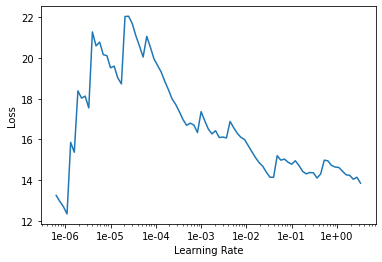

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, 1e-4, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,11.146065,12.829242,2.711464,13:16
1,12.347545,12.970816,2.743859,13:17
2,10.594032,12.784123,2.707160,13:23
3,8.533286,12.757571,2.680598,13:23


Buffered data was truncated after reaching the output size limit.

In [37]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
learn.save('stage-1')

In [39]:
learn.load('stage-1')

Learner(data=TabularDataBunch;

Train: LabelList (4000000 items)
x: TabularList
item_id 2221; dept_id 5; store_id 7; cat_id 2; state_id 2; event_name_1 9; event_name_2 0; event_type_1 1; event_type_2 0; wday -1.4981; month 1.0043; year 0.9381; snap_CA -0.6926; snap_TX -0.7000; snap_WI -0.7008; sell_price -0.1289; lag_7 -0.3320; lag_28 0.6379; rmean_7_7 -0.2983; rmean_28_7 -0.1390; rmean_7_28 -0.1846; rmean_28_28 -0.2468; week 1.1422; quarter 1.3274; mday 1.7381; ,item_id 1957; dept_id 5; store_id 9; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; wday 0.0007; month 0.4306; year 0.9381; snap_CA -0.6926; snap_TX -0.7000; snap_WI -0.7008; sell_price 0.4449; lag_7 -0.0874; lag_28 -0.3271; rmean_7_7 -0.2983; rmean_28_7 -0.2182; rmean_7_28 -0.3189; rmean_28_28 -0.2674; week 0.4869; quarter 0.4451; mday 0.2560; ,item_id 2917; dept_id 6; store_id 7; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; wday -0.4989; month -0

In [40]:
learn.fit_one_cycle(3, 1e-3/2.6**4, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,15.661655,12.981390,2.725305,13:15
1,14.603625,13.138498,2.765918,13:23
2,9.171190,13.215844,2.726499,13:25


In [0]:
learn.save('stage-2')

In [42]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


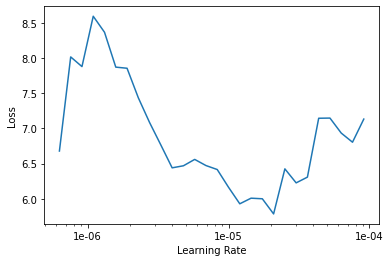

In [43]:
learn.recorder.plot()

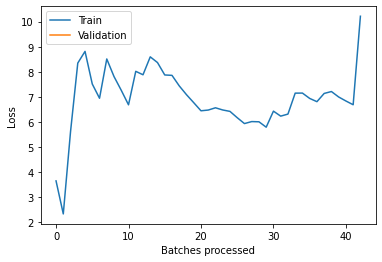

In [45]:
learn.recorder.plot_losses()

In [44]:
learn.load('stage-2')

Learner(data=TabularDataBunch;

Train: LabelList (4000000 items)
x: TabularList
item_id 2221; dept_id 5; store_id 7; cat_id 2; state_id 2; event_name_1 9; event_name_2 0; event_type_1 1; event_type_2 0; wday -1.4981; month 1.0043; year 0.9381; snap_CA -0.6926; snap_TX -0.7000; snap_WI -0.7008; sell_price -0.1289; lag_7 -0.3320; lag_28 0.6379; rmean_7_7 -0.2983; rmean_28_7 -0.1390; rmean_7_28 -0.1846; rmean_28_28 -0.2468; week 1.1422; quarter 1.3274; mday 1.7381; ,item_id 1957; dept_id 5; store_id 9; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; wday 0.0007; month 0.4306; year 0.9381; snap_CA -0.6926; snap_TX -0.7000; snap_WI -0.7008; sell_price 0.4449; lag_7 -0.0874; lag_28 -0.3271; rmean_7_7 -0.2983; rmean_28_7 -0.2182; rmean_7_28 -0.3189; rmean_28_28 -0.2674; week 0.4869; quarter 0.4451; mday 0.2560; ,item_id 2917; dept_id 6; store_id 7; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; wday -0.4989; month -0

In [0]:
learn.export('export.pkl')

In [0]:
temp = test_ds

In [49]:
test_ds

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,F
39803521,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1886,1.0,2016-03-28,11609,1,3,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,1.0,0.0,1.571429,1.142857,1.035714,1.000000,13,1,28,F1
39803522,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1887,0.0,2016-03-29,11609,5,4,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,2.0,1.714286,1.428571,1.107143,1.035714,13,1,29,F2
39803523,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1888,0.0,2016-03-30,11609,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,0.0,1.857143,1.285714,1.142857,1.000000,13,1,30,F3
39803524,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1889,0.0,2016-03-31,11609,4,6,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,0.0,1.0,1.714286,1.428571,1.142857,1.000000,13,1,31,F4
39803525,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1890,0.0,2016-04-01,11609,0,7,4,2016,0,0,0,0,1.0,1.0,0.0,8.26,1.0,1.0,1.428571,1.428571,1.142857,1.035714,13,2,1,F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718214,FOODS_3_825_WI_3_validation_validation,3046,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24,F28
40718215,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23,F27
40718216,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24,F28
40718217,FOODS_3_827_WI_3_validation_validation,3048,6,9,2,2,1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23,F27


In [53]:
temp

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,F
39803521,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1886,1.0,2016-03-28,11609,1,3,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,1.0,0.0,1.571429,1.142857,1.035714,1.000000,13,1,28,F1
39803522,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1887,0.0,2016-03-29,11609,5,4,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,2.0,1.714286,1.428571,1.107143,1.035714,13,1,29,F2
39803523,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1888,0.0,2016-03-30,11609,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,0.0,1.857143,1.285714,1.142857,1.000000,13,1,30,F3
39803524,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1889,0.0,2016-03-31,11609,4,6,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,0.0,1.0,1.714286,1.428571,1.142857,1.000000,13,1,31,F4
39803525,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1890,0.0,2016-04-01,11609,0,7,4,2016,0,0,0,0,1.0,1.0,0.0,8.26,1.0,1.0,1.428571,1.428571,1.142857,1.035714,13,2,1,F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718214,FOODS_3_825_WI_3_validation_validation,3046,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24,F28
40718215,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23,F27
40718216,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24,F28
40718217,FOODS_3_827_WI_3_validation_validation,3048,6,9,2,2,1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23,F27


In [54]:
test_preds=learn.get_preds(DatasetType.Test)

In [0]:
temp["sales"]=np.exp(test_preds[0].data).numpy().T[0]

In [62]:
temp.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,F
40718214,FOODS_3_825_WI_3_validation_validation,3046,6,9,2,2,1913,2.943518,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24,F28
40718215,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1912,3.037309,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23,F27
40718216,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1913,2.901102,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24,F28
40718217,FOODS_3_827_WI_3_validation_validation,3048,6,9,2,2,1912,5.632007,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23,F27
40718218,FOODS_3_827_WI_3_validation_validation,3048,6,9,2,2,1913,4.393092,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,5.0,0.000000,2.428571,1.678571,1.964286,16,2,24,F28


In [0]:
ss = pd.read_csv('sample_submission.csv')

In [64]:
ss

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
submission = temp.pivot(index="id", columns="F", values="sales").reset_index()[ss.columns]

In [66]:
submission

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation_validation,2.007440,1.962160,2.017093,2.215335,2.424634,2.883627,2.177468,2.065223,2.001896,2.024097,2.254190,2.543976,3.028901,2.337078,2.100115,2.129595,2.209143,2.492658,2.832178,3.474530,2.511260,2.264758,2.302095,2.309889,2.525168,2.986898,3.535368,2.484262
1,FOODS_1_001_CA_2_validation_validation,2.312306,2.307518,2.354408,2.666296,2.884776,3.754660,2.431159,2.263546,2.116723,2.143800,2.398747,2.686907,2.886188,2.203044,2.037105,1.984304,2.064070,2.208875,2.480087,2.937729,2.210695,1.919070,1.830920,1.853594,2.038176,2.340606,2.801577,2.215172
2,FOODS_1_001_CA_3_validation_validation,2.247618,2.234028,2.205331,2.393134,2.670743,3.443969,2.694213,2.475031,2.270671,2.266785,2.461186,2.791263,3.163507,2.597028,2.250271,2.165839,2.218015,2.233449,2.504330,3.304581,2.695796,2.345971,2.289294,2.267041,2.398752,2.772266,3.365552,2.578504
3,FOODS_1_001_CA_4_validation_validation,1.786033,1.778788,1.795032,1.869039,2.013592,1.980565,1.878858,1.917451,1.851279,1.836126,1.914725,2.114040,1.989995,1.928661,1.800711,1.772709,1.820120,1.845873,1.965685,2.011196,1.864118,1.799047,1.765351,1.743994,1.758083,1.865112,1.925119,1.774951
4,FOODS_1_001_TX_1_validation_validation,1.825951,1.807186,1.809347,1.893779,2.044008,2.181698,1.970183,1.869693,1.781475,1.767609,1.866288,1.941705,2.074911,1.850843,1.759468,1.760457,1.782301,1.798216,1.941000,2.126516,1.835817,1.736645,1.658479,1.634562,1.636196,1.757581,1.916571,1.646801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation_validation,1.706181,1.689833,1.652902,1.650922,1.701386,1.844377,1.832329,1.688879,1.633869,1.653413,1.674227,1.667019,1.885839,1.829717,1.712792,1.692942,1.686369,1.645253,1.696870,1.872034,1.873630,1.747789,1.709419,1.684882,1.675788,1.654385,1.865415,1.884790
30486,HOUSEHOLD_2_516_TX_3_validation_validation,1.543404,1.535585,1.506891,1.506067,1.543347,1.668784,1.625842,1.554173,1.545716,1.579227,1.559355,1.541964,1.668850,1.610656,1.577076,1.569356,1.567398,1.531453,1.549898,1.736004,1.691700,1.612004,1.576257,1.547631,1.533102,1.517865,1.670969,1.628083
30487,HOUSEHOLD_2_516_WI_1_validation_validation,1.464600,1.446039,1.417407,1.407410,1.498860,1.700291,1.562345,1.452148,1.419797,1.406474,1.413008,1.456488,1.655341,1.527561,1.446911,1.433527,1.418425,1.424396,1.474335,1.689537,1.538236,1.435863,1.414589,1.399754,1.388838,1.494519,1.678431,1.542210
30488,HOUSEHOLD_2_516_WI_2_validation_validation,1.445654,1.431035,1.419597,1.412492,1.477781,1.479710,1.430115,1.421452,1.406491,1.400827,1.429885,1.428689,1.477560,1.415043,1.446701,1.430284,1.429650,1.398856,1.428253,1.504432,1.430601,1.423653,1.410327,1.397670,1.388563,1.403316,1.476342,1.408717
